# IEMS 308 Homework 1 - Melissa Melnick

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

In [2]:
#read in file
file = pd.read_csv('../Desktop/Medicare_Provider_Util_Payment_PUF_CY2018/medicare.txt', sep = '\t')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#slim down originial data set to desired attributes
mo_file = file[file['nppes_provider_state'] == 'MO']
spec_mo_data = mo_file[['nppes_provider_zip', 'bene_unique_cnt', 
                      'average_submitted_chrg_amt', 'average_Medicare_payment_amt']]

In [4]:
#create new column for first zones in Missouri based on first 3 digits of Zip Code
zone_dict= {'631':'STL METRO', '630':'STL METRO', '633':'STL METRO', '635':'NORTHEAST', 
           '634':'NORTHEAST', '652':'NORTHEAST', '650':'NORTHEAST', '651':'NORTHEAST',
           '636': 'SOUTHEAST', '637': 'SOUTHEAST', '638': 'SOUTHEAST', '639': 'SOUTHEAST', 
            '655': 'SOUTHEAST', '654': 'SOUTHEAST', '641': 'KC METRO', '640': 'KC METRO',
           '653': 'SOUTHWEST', '647': 'SOUTHWEST', '657': 'SOUTHWEST', '648': 'SOUTHWEST',
           '656': 'SOUTHWEST', '658': 'SOUTHWEST', '644': 'NORTHWEST', '645': 'NORTHWEST', 
            '646': 'NORTHWEST'}

spec_mo_data.loc[:, 'zone'] = spec_mo_data['nppes_provider_zip'].astype(str).str[0:3]
spec_mo_data.loc[:, 'zone'].replace(zone_dict, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [5]:
#delete original zip code column
del spec_mo_data['nppes_provider_zip']

In [6]:
#delete incorrect zips
spec_mo_data = spec_mo_data[spec_mo_data.loc[:,'zone'].isin(zone_dict.values())]

In [7]:
#turn zone into dummy variables and add to dataset
spec_mo_data = pd.concat([spec_mo_data,pd.get_dummies(spec_mo_data['zone'],prefix='zone')],axis=1)

In [8]:
#drop original zone column
spec_mo_data.drop(['zone'],axis=1, inplace=True)

In [9]:
#remove outliers
cols_of_interest = ['bene_unique_cnt', 'average_submitted_chrg_amt', 'average_Medicare_payment_amt']
for column in cols_of_interest:
    try:
        mean = spec_mo_data[column].mean()
        stddev = spec_mo_data[column].std()
        for value in spec_mo_data[column]: 
            if value > mean + 2*stddev:
                spec_mo_data = spec_mo_data[spec_mo_data[column] != value]
            elif value < mean - 2*stddev:
                spec_mo_data = spec_mo_data[spec_mo_data[column] != value]  
    except:
        continue
      

In [10]:
#reset indices on pared down data set
spec_mo_data.reset_index(drop=True, inplace=True)

In [11]:
#scale the data
scale_tech = preprocessing.StandardScaler().fit(spec_mo_data)
mo_dat_scaled = scale_tech.transform(spec_mo_data)

In [12]:
#create dataframe of scaled data
mdc = pd.DataFrame(mo_dat_scaled)

Text(0, 0.5, 'Performance')

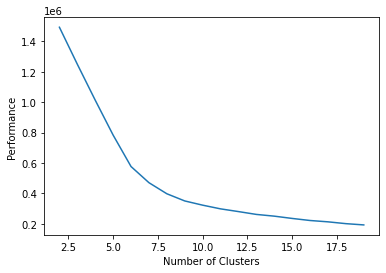

In [13]:
#find optimal number of clusters
sse = []
for clusters in range(2,20):
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(mo_dat_scaled)
    sse.append(kmeans.inertia_)
    
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
ax.plot(range(2,20),sse)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Performance")

In [14]:
#run kmeans
kmeans = KMeans(n_clusters =6)
kmeans = kmeans.fit(mo_dat_scaled)
labels = kmeans.predict(mo_dat_scaled)
centroids = kmeans.cluster_centers_

In [15]:
#turn the clusters into a series to be added to dataframe
label_col = pd.Series(labels)
label_col

0         3
1         3
2         3
3         0
4         0
         ..
192911    2
192912    2
192913    2
192914    2
192915    2
Length: 192916, dtype: int32

In [17]:
spec_mo_data = pd.concat([spec_mo_data,pd.DataFrame(label_col, columns=["Cluster"])],axis=1)

In [18]:
spec_mo_data['Cluster'].value_counts()

0    77641
4    36026
5    32518
2    24446
1    16860
3     5425
Name: Cluster, dtype: int64

In [19]:
spec_mo_data

,bene_unique_cnt,average_submitted_chrg_amt,average_Medicare_payment_amt,zone_KC METRO,zone_NORTHEAST,zone_NORTHWEST,zone_SOUTHEAST,zone_SOUTHWEST,zone_STL METRO,Cluster
0,291.0,69.742268,52.208935,0,0,1,0,0,0,3
1,30.0,35.000000,18.650000,0,0,1,0,0,0,3
2,321.0,25.000000,18.520000,0,0,1,0,0,0,3
3,26.0,120.000000,48.601930,0,0,0,0,0,1,0
4,29.0,140.000000,75.194697,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
192911,16.0,75.000000,32.200000,0,1,0,0,0,0,2
192912,12.0,106.000000,54.180000,0,1,0,0,0,0,2
192913,216.0,160.422311,76.992151,0,1,0,0,0,0,2
192914,112.0,225.897638,103.588268,0,1,0,0,0,0,2


In [20]:
#look at data
mo_dat_pp = spec_mo_data.groupby(["Cluster"])

mo_dat_pp_mean = mo_dat_pp.mean()
mo_dat_pp_mean

,bene_unique_cnt,average_submitted_chrg_amt,average_Medicare_payment_amt,zone_KC METRO,zone_NORTHEAST,zone_NORTHWEST,zone_SOUTHEAST,zone_SOUTHWEST,zone_STL METRO
Cluster,,,,,,,,,
0,63.101544,237.157214,56.195835,0,0,0,0,0,1
1,74.391340,237.524044,47.287634,0,0,0,1,0,0
2,67.882762,216.395654,49.634866,0,1,0,0,0,0
3,72.544516,209.294697,55.352187,0,0,1,0,0,0
4,65.893577,210.956379,55.724893,1,0,0,0,0,0
5,66.905252,199.032762,48.383723,0,0,0,0,1,0
